In [ ]:
!pip install snowflake
!pip install snowflake-snowpark-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.9/443.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.4/450.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 11.1 MB/s eta 0:00:00


In [ ]:
from snowflake.snowpark.session import Session
import sys
from snowflake.snowpark.functions import col, lit, sum as sum_, max as max_
# Import library for analysis

import numpy as np # Algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #Chart
import seaborn as sns # Analisis
import os # File Manager
from datetime import datetime # Date Manipulation

In [ ]:
# snowflake_connection_parameters = {
#     "account" : "lqofjia-jr27907"
#   , "user" : "HOSSAMTAREK"
#   , "password" : "123456789@Sh"
#   ,"role" : "ACCOUNTADMIN"
#   ,"warehouse" : "COMPUTE_WH"
# }
snowflake_connection_parameters = {
   "user":"BIGDATA",
    "account":"BNYTXUB-TH07367",
    "password":"Ffbuxv5.RsM.ZQm",
    "database":"BIG_DATA_PROJECT",
    "schema":"PUBLIC"
}
TABLE_NAME="TAXI_TRIPS_CLEANED"

In [ ]:
snowpark_session = Session.builder.configs(snowflake_connection_parameters).create()


In [ ]:
snowpark_session.sql("USE DATABASE BIG_DATA_PROJECT").show()

------------------------------------
|"status"                          |
------------------------------------
|Statement executed successfully.  |
------------------------------------



In [ ]:
taxi_df = snowpark_session.table(TABLE_NAME)


In [ ]:
taxi_df.count()

10106061

In [ ]:
taxi_df.columns

['VENDORID',
 'PASSENGER_COUNT',
 'TRIP_DISTANCE',
 'PULOCATIONID',
 'DOLOCATIONID',
 'PAYMENT_TYPE',
 'FARE_AMOUNT',
 'EXTRA',
 'MTA_TAX',
 'TIP_AMOUNT',
 'TOLLS_AMOUNT',
 'IMPROVEMENT_SURCHARGE',
 'TOTAL_AMOUNT',
 'CONGESTION_SURCHARGE',
 'PICKUP_TIMESTAMP',
 'DROPOFF_TIMESTAMP']

# Data analysis

In [ ]:
pd_taxi=taxi_df.select("PICKUP_TIMESTAMP","trip_distance","tip_amount","fare_amount").toPandas()

In [ ]:
pd_taxi.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10106061 entries, 0 to 10106060
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   PICKUP_TIMESTAMP  datetime64[ns]
 1   TRIP_DISTANCE     float64       
 2   TIP_AMOUNT        float64       
 3   FARE_AMOUNT       float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 308.4 MB


###The busiest hour


In [ ]:

pd_taxi['hour_pickup'] = pd.to_datetime(pd_taxi['PICKUP_TIMESTAMP']).dt.hour


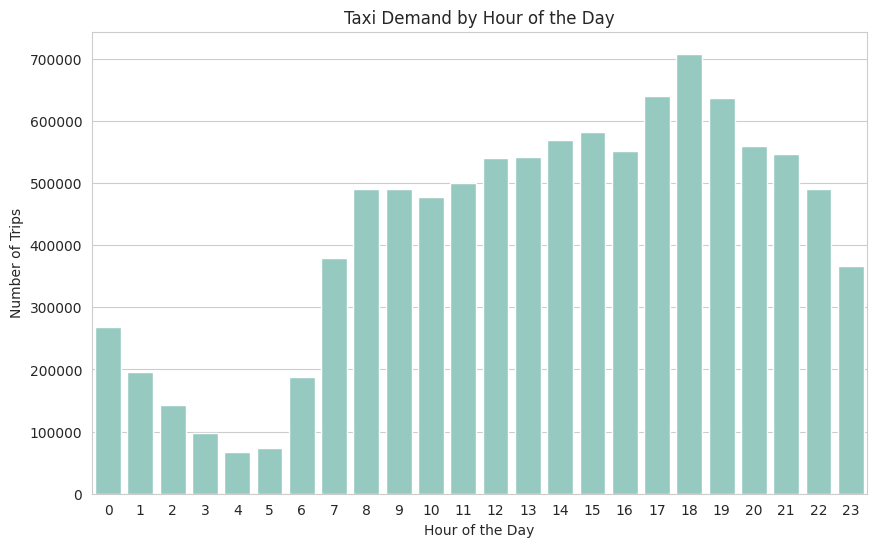

In [ ]:

sns.set_style("whitegrid")
sns.set_palette("Set3")

plt.figure(figsize=(10, 6))
sns.countplot(x='hour_pickup', data=pd_taxi)
plt.title('Taxi Demand by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()


###Analyze more frequent day of the week

In [ ]:
pd_taxi['day_pickup'] = pd_taxi['PICKUP_TIMESTAMP'].dt.day_name()

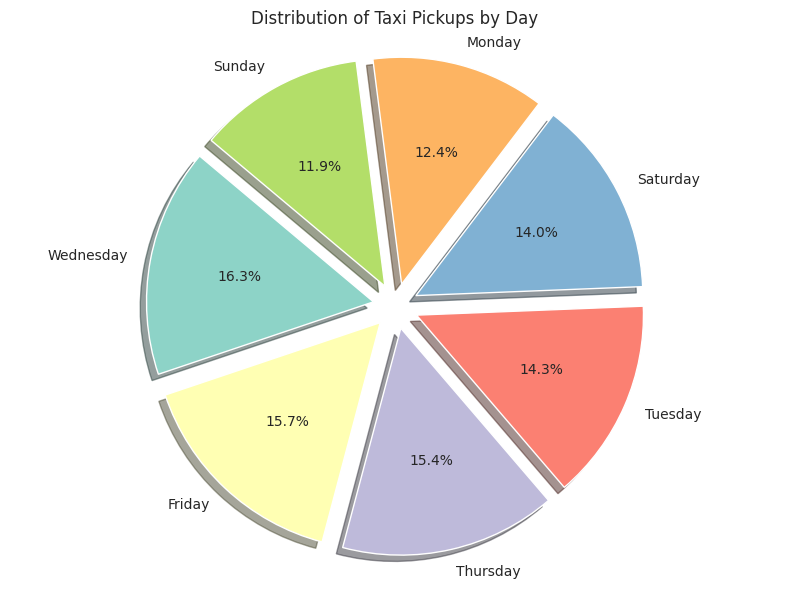

In [ ]:
day_counts = pd_taxi['day_pickup'].value_counts()

plt.figure(figsize=(8, 6))
colors = plt.cm.Set3.colors
explode = [0.1] * len(day_counts)

plt.pie(day_counts, labels=day_counts.index, autopct='%1.1f%%', startangle=140,
        colors=colors, explode=explode, shadow=True)

plt.title('Distribution of Taxi Pickups by Day')
plt.axis('equal')
plt.tight_layout()
plt.show()

###Correlation between trip distances and fare amount

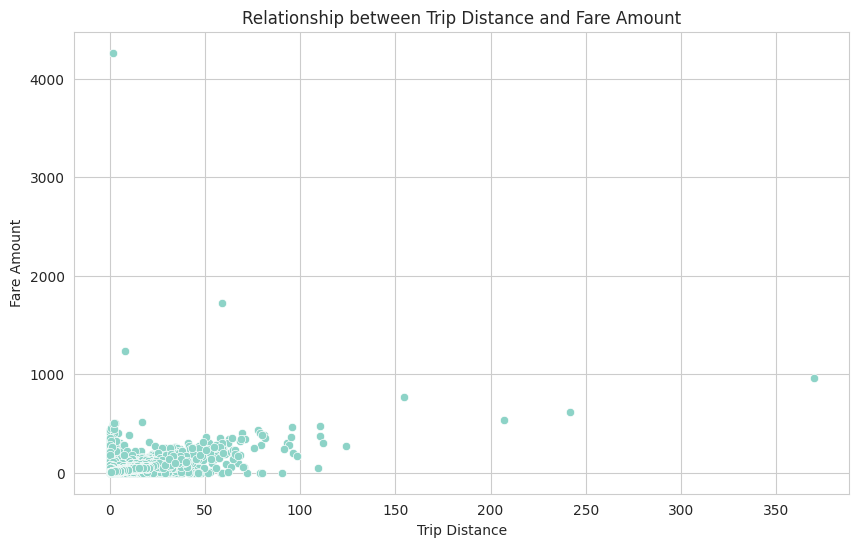

In [ ]:
pd_taxi_mini= pd_taxi.sample(frac=0.1, random_state=42)  # Sampling 10% of the data

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TRIP_DISTANCE', y='FARE_AMOUNT', data=pd_taxi)
plt.title('Relationship between Trip Distance and Fare Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

###Correlation between trip distances and tip amount

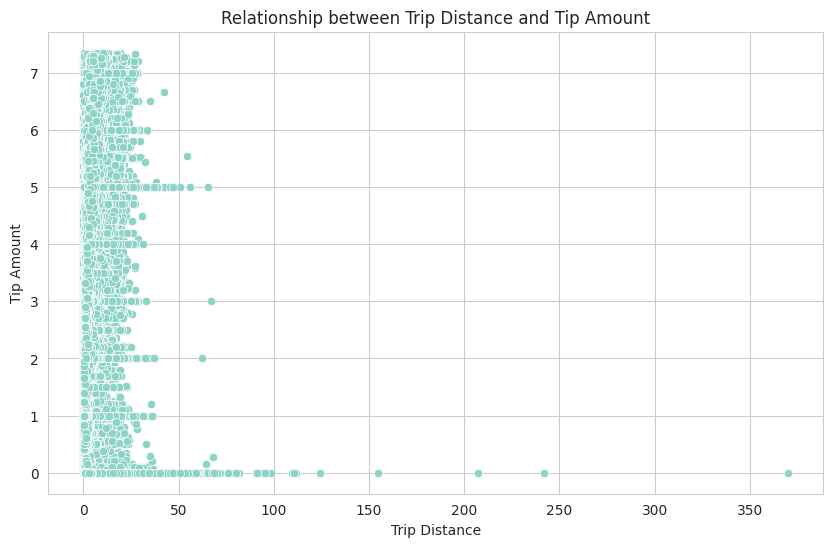

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TRIP_DISTANCE', y='TIP_AMOUNT', data=pd_taxi)
plt.title('Relationship between Trip Distance and Tip Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Tip Amount')
plt.show()

###Total Paid vs Pickup Location ID

In [ ]:
taxi_df.select("PULOCATIONID").distinct().count()

259

In [ ]:
taxi_dfpul=taxi_df.group_by("PULOCATIONID").agg(sum_("TOTAL_AMOUNT").alias("TOTAL_PAID")).orderBy("TOTAL_PAID", ascending=False).toPandas()

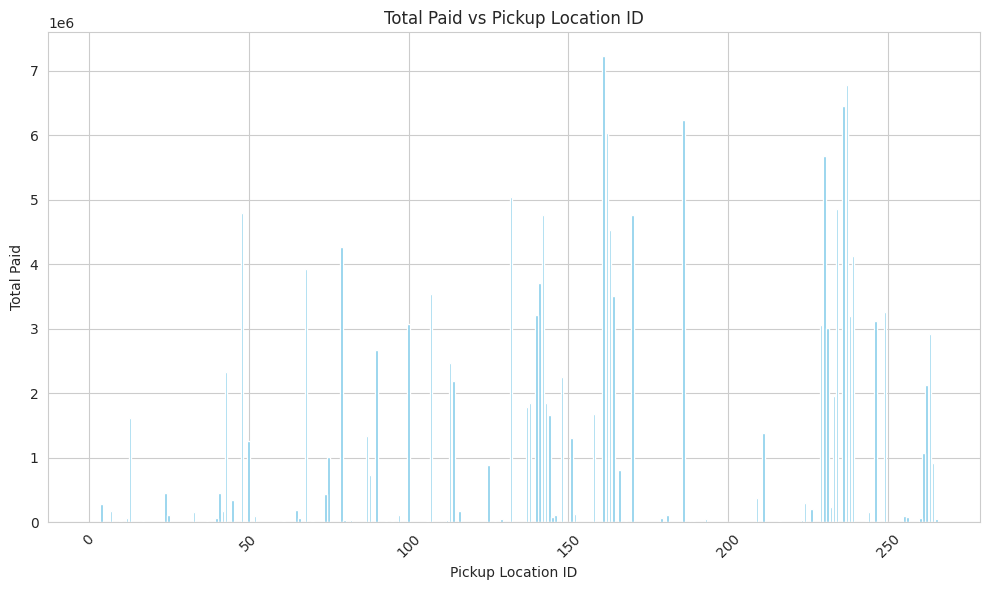

In [ ]:
location_ids = taxi_dfpul['PULOCATIONID']
total_paid = taxi_dfpul['TOTAL_PAID']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(location_ids, total_paid, color='skyblue')
plt.title('Total Paid vs Pickup Location ID')
plt.xlabel('Pickup Location ID')
plt.ylabel('Total Paid')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [ ]:
snowpark_session.close()